# Отток клиентов

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Bank_Creative_Tail.svg/480px-Bank_Creative_Tail.svg.png 'Creative Tail')

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Успешными будем считать решения с метрикой от 0,59 на валидации.

Дополнительно измерим метрику *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Загрузим полученные данные и посмотрим на них.

In [93]:
! gdown 1uRR7sKZV-Mm0KGE8yNJ3R85hvrayN6Sa

Downloading...
From: https://drive.google.com/uc?id=1uRR7sKZV-Mm0KGE8yNJ3R85hvrayN6Sa
To: /content/Churn.csv
100% 710k/710k [00:00<00:00, 105MB/s]


In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier

import warnings

In [95]:
warnings.simplefilter("ignore")

In [96]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

In [97]:
df = pd.read_csv('/content/Churn.csv', index_col='RowNumber')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [99]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
Exited,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [100]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Итак, нам доступен файл с 10000 записей. В колонках содержатся следующие данные:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата
* `Exited` — факт ухода клиента.

Видно, что данные требуют предварительной обработки: для удобства дальнейшией работы можно изменить названия колонок  и обработать пропуски данных в колонке `Tenure` (пропуски видны в выводе команды *info*). Затем надо будет обработать категориальные признаки.

### Переименование колонок

In [101]:
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()

In [102]:
# контроль
df.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [103]:
df.index = df.index.rename('row_number')

In [104]:
df.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Обработка пропусков данных

Обработаем пропуски данных в колонке `tenure`. Пропуски могли возникнуть из-за технической ошибки, скорее всего у банка достаточно информации о том, сколько лет клиент обслуживается у них. Заполним пропуски медианным значением в зависимости от возраста клиента. Это скорее всего не исказит наше исследование, так как пропусков не много, а из вывода команды *describe* видно, что эта переменная распределена без заметных выбросов.

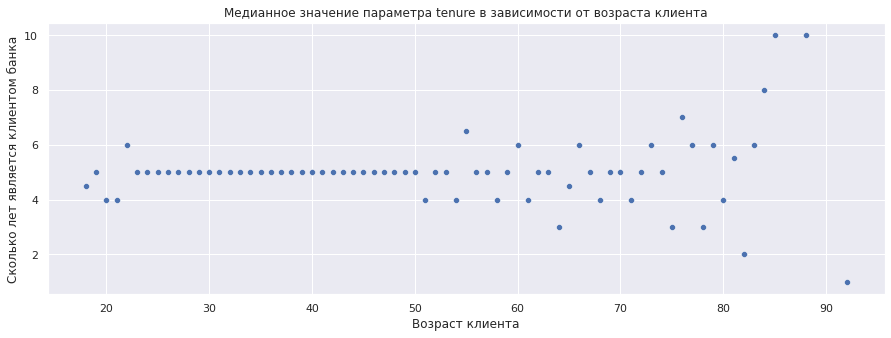

In [105]:
sns.scatterplot(data=df.groupby('age').agg({'tenure': 'median'}), x='age', y='tenure')
plt.title('Медианное значение параметра tenure в зависимости от возраста клиента')
plt.xlabel('Возраст клиента')
plt.ylabel('Сколько лет является клиентом банка')
plt.show()

In [106]:
df['tenure'] = df['tenure'].fillna(df.groupby(['age'])['tenure'].transform('median'))

In [107]:
# контроль
df['tenure'].isna().sum()

0

После обработки пропусков данных изменим тип данных в колонке на целочисленный _(int64)_.

In [108]:
df['tenure'] = df['tenure'].astype('int64')

In [109]:
# контроль
df.dtypes.to_frame()

,0
customer_id,int64
surname,object
credit_score,int64
geography,object
gender,object
age,int64
tenure,int64
balance,float64
num_of_products,int64
has_cr_card,int64


### Исследовательский анализ данных

Познакомимся с данными поближе. Посмотрим, есть ли в каких-нибудь колонках выбросы или подозрительные значения.

#### `credit_score`

In [110]:
df['credit_score'].describe().to_frame()

,credit_score
count,10000.000000
mean,650.528800
std,96.653299
min,350.000000
25%,584.000000
50%,652.000000
75%,718.000000
max,850.000000


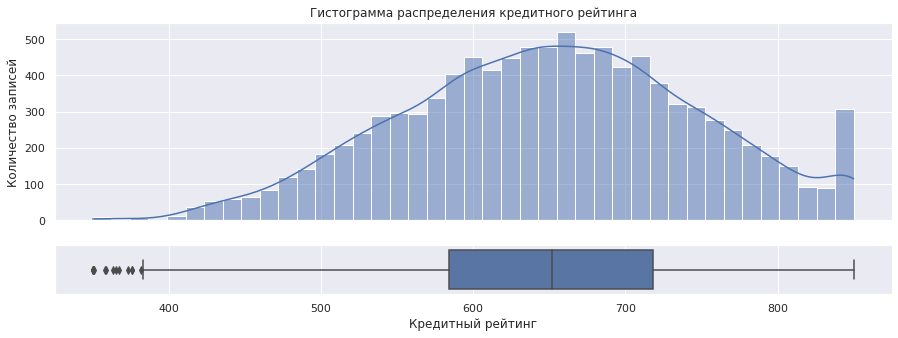

In [111]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='credit_score', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения кредитного рейтинга',
     ylabel='Количество записей')
sns.boxplot(data=df, x='credit_score', ax=axs_box)\
.set(xlabel='Кредитный рейтинг');

Значения кредитного рейтинга лежат в диапазоне от 350 до 850, медианное значение — 652, что довольно близко к среднему (650). Распределение похоже на нормальное, но наблюдается довольно большое количество записей с кредитным рейтингом около 850.

#### `geography`

In [112]:
df['geography'].value_counts().to_frame()

,geography
France,5014
Germany,2509
Spain,2477


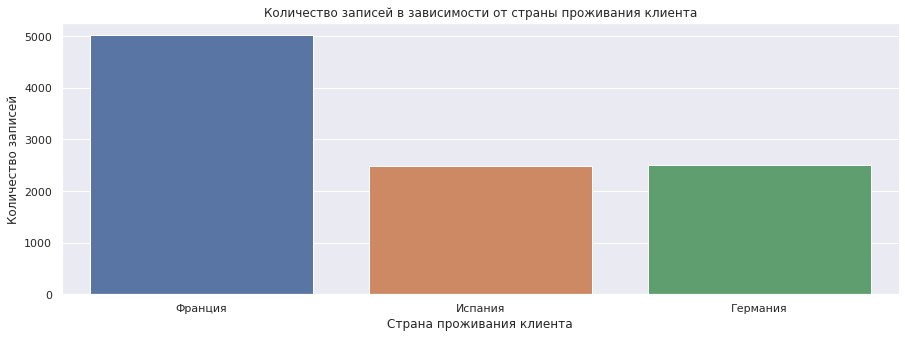

In [113]:
ax = sns.countplot(data=df, x='geography')
ax.set(xticklabels = (['Франция', 'Испания', 'Германия']))
plt.title('Количество записей в зависимости от страны проживания клиента')
plt.xlabel('Страна проживания клиента')
plt.ylabel('Количество записей')
plt.show()

Видно, что в таблице представлены данные о клиентах из трёх стран: Франции, Испании и Германии. Больше всего данных о пользователях из Франции.

#### `gender`

In [114]:
df['gender'].value_counts().to_frame()

,gender
Male,5457
Female,4543


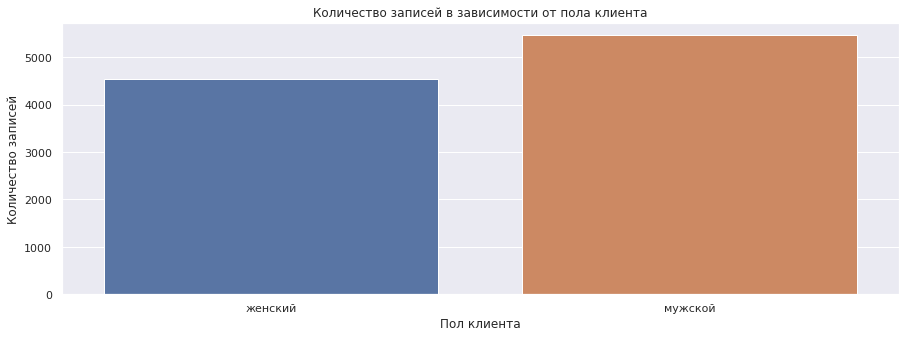

In [115]:
ax = sns.countplot(data=df, x='gender')
ax.set(xticklabels = (['женский', 'мужской']))
plt.title('Количество записей в зависимости от пола клиента')
plt.xlabel('Пол клиента')
plt.ylabel('Количество записей')
plt.show()

В таблице представлены данные о клиентах-мужчинах и женщинах. Видно, что данных о клиентах-мужчинах несколько больше, но не настолько, чтобы говорить о существенном перекосе.

#### `age`

In [116]:
df['age'].describe().to_frame()

,age
count,10000.000000
mean,38.921800
std,10.487806
min,18.000000
25%,32.000000
50%,37.000000
75%,44.000000
max,92.000000


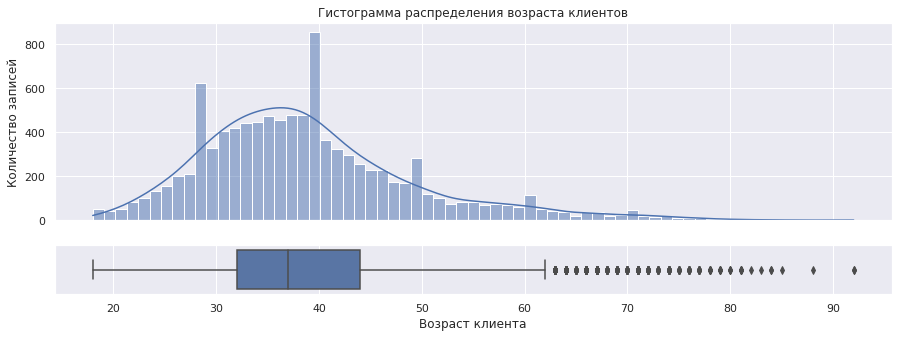

In [117]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='age', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения возраста клиентов',
     ylabel='Количество записей')
sns.boxplot(data=df, x='age', ax=axs_box)\
.set(xlabel='Возраст клиента');

Значения возрастов клиентов лежат в диапазоне от 18 до 92 лет, медианное значение — 37 лет, что довольно близко к среднему (39 лет). Распределение не похоже на нормальное, имеется довольно длинный правый хвост. На гистограмме видны подозрительные "выбросы" для возрастов 28, 40, 50, 60 лет. Возможно это ошибки в данных, но сделать аргументированное предположение о природе их возникновения довольно сложно.

#### `tenure`

In [118]:
df['tenure'].describe().to_frame()

,tenure
count,10000.000000
mean,4.994900
std,2.761854
min,0.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,10.000000


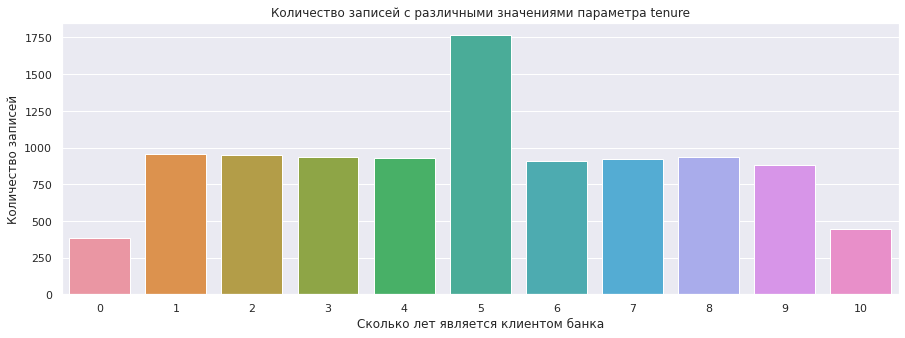

In [119]:
sns.countplot(data=df, x='tenure')\
.set(title='Количество записей с различными значениями параметра tenure',
     xlabel='Сколько лет является клиентом банка',
     ylabel='Количество записей');

Значения параметра `tenure` лежат в диапазоне от 0 до 10 лет, медианное и среднее занчения — 5 лет. На графике видна мода на значении 5 лет.

#### `balance`

In [120]:
df['balance'].describe().to_frame()

,balance
count,10000.000000
mean,76485.889288
std,62397.405202
min,0.000000
25%,0.000000
50%,97198.540000
75%,127644.240000
max,250898.090000


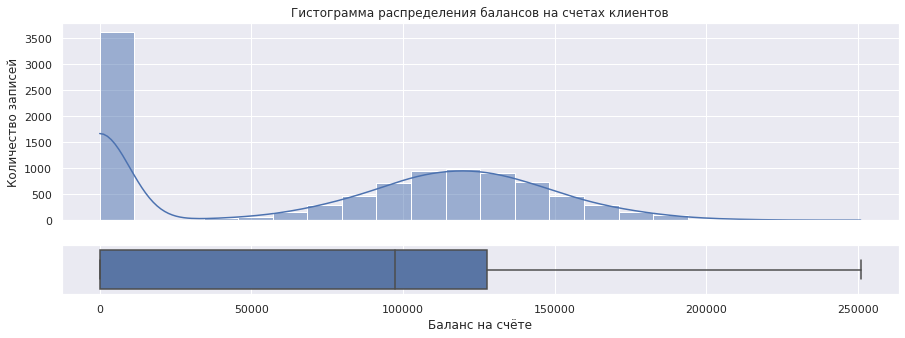

In [121]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='balance', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения балансов на счетах клиентов',
     ylabel='Количество записей')
sns.boxplot(data=df, x='balance', ax=axs_box)\
.set(xlabel='Баланс на счёте');

Значения балансов на счетах лежат в диапазоне от 0 до 250 тысяч, медианное значение — 97 тысяч, среднее — 76 тысяч. На гистограмме видно, что у значительного количества клиентов нулевой баланс на счёте, что печально.

#### `num_of_products`

In [122]:
df['num_of_products'].describe().to_frame()

,num_of_products
count,10000.000000
mean,1.530200
std,0.581654
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


In [123]:
df['num_of_products'].value_counts().to_frame()

,num_of_products
1,5084
2,4590
3,266
4,60


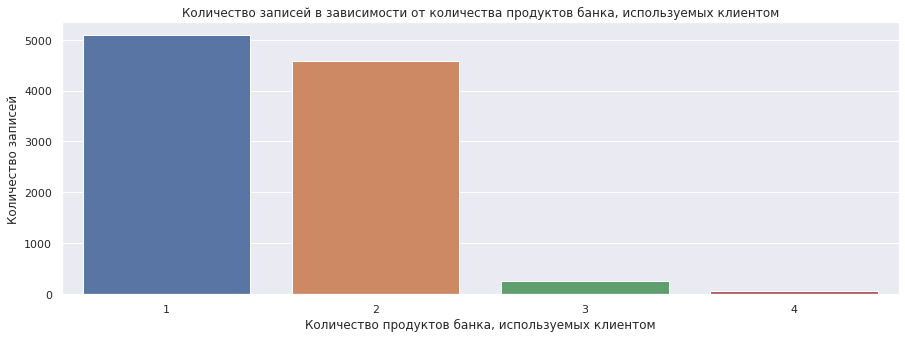

In [124]:
sns.countplot(data=df, x='num_of_products')
plt.title('Количество записей в зависимости от количества продуктов банка, используемых клиентом')
plt.xlabel('Количество продуктов банка, используемых клиентом')
plt.ylabel('Количество записей')
plt.show()

Видно, что клиенты банка используют от 1 до 4 продуктов банка. При этом подавляющее большинство клиентов используют 1—2 продукта.

#### `has_cr_card`

In [125]:
df['has_cr_card'].value_counts().to_frame()

,has_cr_card
1,7055
0,2945


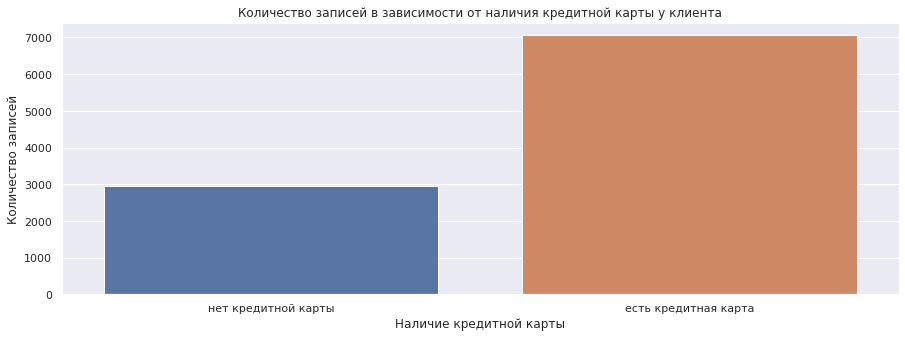

In [126]:
ax = sns.countplot(data=df, x='has_cr_card')
ax.set(xticklabels = (['нет кредитной карты', 'есть кредитная карта']))
plt.title('Количество записей в зависимости от наличия кредитной карты у клиента')
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Количество записей')
plt.show()

Видно, что у большниства клиентов банка есть кредитная карта. Менеджеры потрудились на славу!

#### `is_active_member`

In [127]:
df['is_active_member'].value_counts().to_frame()

,is_active_member
1,5151
0,4849


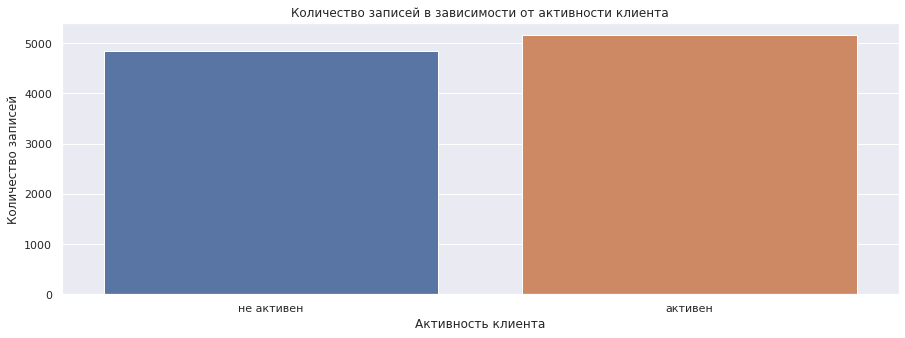

In [128]:
ax = sns.countplot(data=df, x='is_active_member')
ax.set(xticklabels = (['не активен', 'активен']))
plt.title('Количество записей в зависимости от активности клиента')
plt.xlabel('Активность клиента')
plt.ylabel('Количество записей')
plt.show()

Записи об активных и не активных клиентах банка распределены примерно поровну.

#### `estimated_salary`

In [129]:
df['estimated_salary'].describe().to_frame()

,estimated_salary
count,10000.000000
mean,100090.239881
std,57510.492818
min,11.580000
25%,51002.110000
50%,100193.915000
75%,149388.247500
max,199992.480000


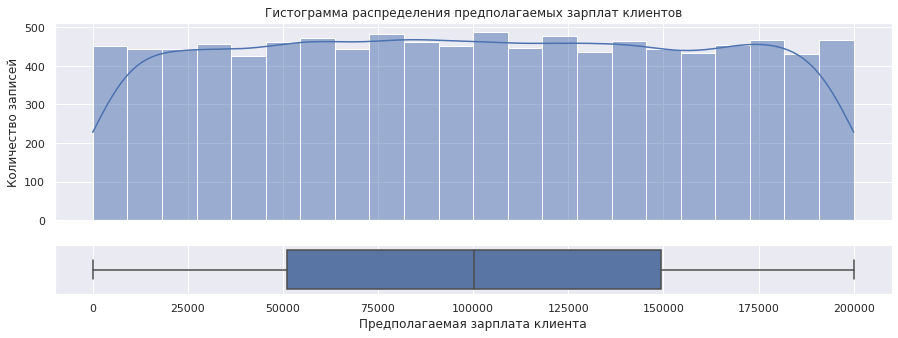

In [130]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='estimated_salary', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения предполагаемых зарплат клиентов',
     ylabel='Количество записей')
sns.boxplot(data=df, x='estimated_salary', ax=axs_box)\
.set(xlabel='Предполагаемая зарплата клиента');

Значения предполагаемых зарплат клиентов лежат в диапазоне от 12 до 200000, медианное значение — 100 тысяч, что довольно близко к среднему. При этом распределение предполагаемых зарплат выглядит неправдоподобно — количество записей практически не зависит от предполагаемой зарплаты, хотя можно было бы предположить, что распределение будет больше напоминать нормальное. Возможно это связано с какими-то ошибками в данных, но для проверки этой гипотезы требуется дополнительное исследование. Построим также график зависимости оценки заработной платы от возраста. Можно предположить, что у молодых и пожилых клиентов зарплата будет ниже, чем у клиентов среднего возраста.

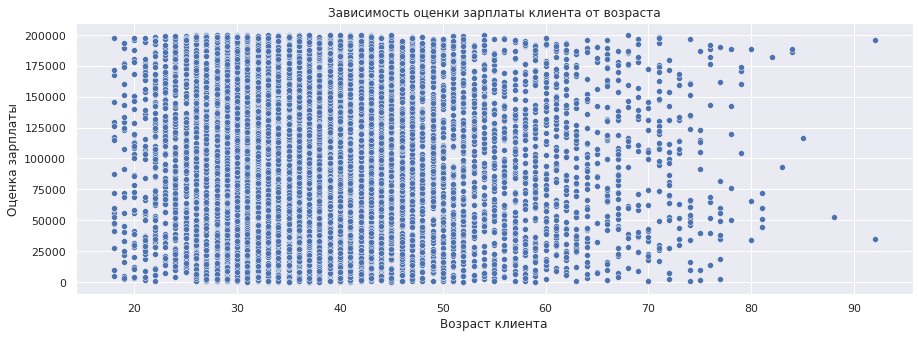

In [131]:
sns.scatterplot(data=df, y='estimated_salary', x='age')
plt.title('Зависимость оценки зарплаты клиента от возраста')
plt.xlabel('Возраст клиента')
plt.ylabel('Оценка зарплаты')
plt.show()

На графике не наблюдается существенной разницы в разбросах зарплат между клиентами 18, 40 и 70 лет, что довольно подозрительно.

#### `exited`

In [132]:
df['exited'].value_counts().to_frame()

,exited
0,7963
1,2037


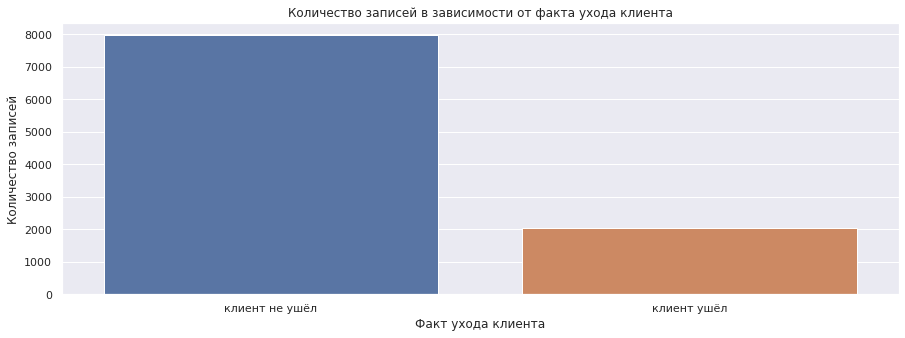

In [133]:
ax = sns.countplot(data=df, x='exited')
ax.set(xticklabels = (['клиент не ушёл', 'клиент ушёл']))
plt.title('Количество записей в зависимости от факта ухода клиента')
plt.xlabel('Факт ухода клиента')
plt.ylabel('Количество записей')
plt.show()

Видно, что в нашей таблице наблюдается дисбаланс классов — данных о клиентах, оставшихся в банке, заметно больше. Это может оказаться важным при построении моделей.

### Определение корреляций

Построим матрицу корреляций для наших данных.

In [134]:
df.corr()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,1.000000,0.005308,0.009497,-0.020297,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
credit_score,0.005308,1.000000,-0.003965,-0.000307,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.009497,-0.003965,1.000000,-0.014674,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.020297,-0.000307,-0.014674,1.000000,-0.007417,0.011707,0.026293,-0.031062,0.009343,-0.015968
balance,-0.012419,0.006268,0.028308,-0.007417,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.016972,0.012238,-0.030680,0.011707,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.014025,-0.005458,-0.011721,0.026293,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.001665,0.025651,0.085472,-0.031062,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,0.015271,-0.001384,-0.007201,0.009343,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.006248,-0.027094,0.285323,-0.015968,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


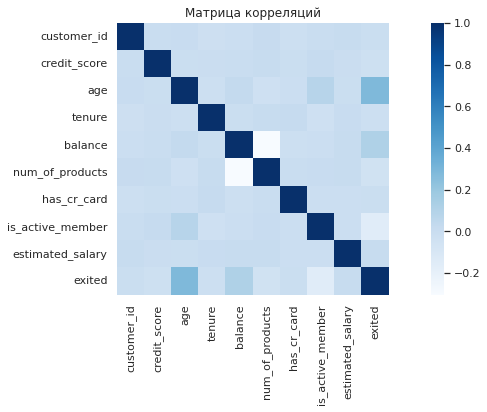

In [135]:
sns.heatmap(df.corr(), square=True, cmap='Blues')\
.set(title='Матрица корреляций');

Видно, что между данными в различных колонках почти не наблюдается корреляции.

### Обработка дубликатов

Посмотрим, есть ли в наших данных дубликаты.

In [136]:
df.duplicated().sum()

0

В данных явных дубликатов не обнаружено.

### Обработка категориальных переменных

В нашей таблице три колонки содержат категориальные переменные: `surname`, `geography`, `gender`. 

Колонка `surname` вряд ли будет полезна при обучении моделей, вынесем её в отдельную таблицу-словарь.

In [137]:
surname_dict = df[['customer_id', 'surname']].copy()

In [138]:
# контроль
surname_dict.head()

,customer_id,surname
row_number,,
1,15634602,Hargrave
2,15647311,Hill
3,15619304,Onio
4,15701354,Boni
5,15737888,Mitchell


In [139]:
del df['surname']

In [140]:
# контроль
df.head()

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,,,,,,,,,,,,
1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Колонки `geography`, `gender` обработаем методом _One-Hot Encoding_ (метод _Ordinal Encoding_ в данном случае не подходит, так как категории не подразумевают сортировки)

In [141]:
df = pd.get_dummies(data=df, columns=['geography', 'gender'], drop_first=True)

In [142]:
# контроль
df.head()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
row_number,,,,,,,,,,,,,
1,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Промежуточные выводы

Была произведена обработка полученных данных. Были изменены названия колонок. В колонке `tenure` были обнаружены и обработаны пропуски данных.

В результате исследовательского анализа были обнаружены подозрительные данные в колонках `age` и `estimated_salary`. Было установлено, что в колонке с целевой переменной `exited` большая часть записей имеет значение 0 (клиент не ушёл). Явных дубликатов данных обнаружено не было.

Были также обработаны колонки с категориальными переменными. Колонка `surname` была вынесена в отдельную таблицу-словарь и удалена из общей таблицы; колонки `geography`, `gender` были обработаны методом _One-Hot Encoding_.

## Исследование задачи

На этапе подготовки данных мы обнаружили, что в имеющихся данных относительно мало записей о клиентах, ушедших из банка. Посмотрим, как это скажется на наших моделях. Для начала обучим несколько моделей без учёта дисбаланса классов. Будем применять логистический регрессор, случайный лес, метод ближайших соседей и метод опорных векторов. Оценку модели будем производить по метрике _F1_

Создадим функцию, автоматизирующую процесс получения метрик для моделей.

In [143]:
def get_scores(X_trn, y_trn):
    # логистическая регрессия
    lr = LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1)
    lr_params = {'C': [.5, .6, .7, .8, .9, 1.]}
    
    lr_model = RandomizedSearchCV(estimator=lr, 
                                  param_distributions=lr_params, 
                                  scoring='f1', n_jobs=-1, 
                                  random_state=42)
    lr_model.fit(X_trn, y_trn)
        
    lr_f1 = cross_val_score(lr_model.best_estimator_, 
                            X_trn, y_trn, n_jobs=-1, 
                            scoring='f1')
    lr_auc = cross_val_score(lr_model.best_estimator_, 
                             X_trn, y_trn, n_jobs=-1, 
                             scoring='roc_auc')
    
    print('Логистическая регрессия')
    print('Метрика F1:', round(lr_f1.mean(), 2))
    print('Метрика AUC:', round(lr_auc.mean(), 2))
    print()
          
    # случайный лес
    rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    rfc_params = {'n_estimators': [80, 100, 120],
                  'max_depth': range(5, 20, 2)}
    
    rfc_model = RandomizedSearchCV(estimator=rfc, 
                                   param_distributions=rfc_params, 
                                   scoring='f1', n_jobs=-1, 
                                   random_state=42)
    rfc_model.fit(X_trn, y_trn)
    
    rfc_f1 = cross_val_score(rfc_model.best_estimator_, 
                             X_trn, y_trn, n_jobs=-1, 
                             scoring='f1')
    rfc_auc = cross_val_score(rfc_model.best_estimator_, 
                              X_trn, y_trn, n_jobs=-1, 
                              scoring='roc_auc')
    
    print('Случайный лес')
    print('Метрика F1:', round(rfc_f1.mean(), 2))
    print('Метрика AUC:', round(rfc_auc.mean(), 2))
    print()
    
    # ближайшие соседи
    knc = KNeighborsClassifier(n_jobs=-1)
    knc_params = {'weights': ['uniform', 'distance'],
                  'n_neighbors': range(2, 10, 1)}
    
    knc_model = RandomizedSearchCV(estimator=knc, 
                                   param_distributions=knc_params, 
                                   scoring='f1', n_jobs=-1, 
                                   random_state=42)
    knc_model.fit(X_trn, y_trn)
    
    knc_f1 = cross_val_score(knc_model.best_estimator_, 
                             X_trn, y_trn, n_jobs=-1, 
                             scoring='f1')
    knc_auc = cross_val_score(knc_model.best_estimator_, 
                              X_trn, y_trn, n_jobs=-1, 
                              scoring='roc_auc')
    
    print('Метод k-ближайших соседей')
    print('Метрика F1:', round(knc_f1.mean(), 2))
    print('Метрика AUC:', round(knc_auc.mean(), 2))
    print()
    
    # опорные вектора
    svc = SVC(random_state=42)
    svc_params = {'C': [.5, .6, .7, .8, .9, 1.]}
    svc_model = RandomizedSearchCV(estimator=svc, 
                                   param_distributions=svc_params, 
                                   scoring='f1', n_jobs=-1, 
                                   random_state=42)
    svc_model.fit(X_trn, y_trn)
    
    svc_f1 = cross_val_score(svc_model.best_estimator_, 
                             X_trn, y_trn, n_jobs=-1, 
                             scoring='f1')
    svc_auc = cross_val_score(svc_model.best_estimator_, 
                              X_trn, y_trn, n_jobs=-1, 
                              scoring='roc_auc')
    
    print('Метод опорных векторов')
    print('Метрика F1:', round(svc_f1.mean(), 2))
    print('Метрика AUC:', round(svc_auc.mean(), 2))
    
    # графики на всякий случай. вдруг у нас на кросс-валидации огромные разбросы и выборки пересекаются
    names = ['Логистическая регрессия', 'Случайный лес', 
             'Метод k-ближайших соседей', 'Метод опорных векторов']
    f1_scores = pd.DataFrame([lr_f1, rfc_f1, knc_f1, svc_f1], index=names)
    sns.boxplot(data=f1_scores.T, orient='h', showmeans=True, 
                    meanprops={'marker': 'x',
                               'markeredgecolor': 'black',
                               'markersize': '10'})
    plt.title('Диаграммы размаха метрик F1 на кросс-валидации')
    plt.xlabel('F1')
    plt.ylabel('Модель')
    plt.show()
    
    auc_scores = pd.DataFrame([lr_auc, rfc_auc, knc_auc, svc_auc], index=names)
    sns.boxplot(data=auc_scores.T, orient='h', showmeans=True, 
                    meanprops={'marker': 'x',
                               'markeredgecolor': 'black',
                               'markersize': '10'})
    plt.title('Диаграммы размаха метрик ROC AUC на кросс-валидации')
    plt.xlabel('ROC AUC')
    plt.ylabel('Модель')
    plt.show()

### Исходные параметры
Разделим данные на отдельные таблицы с параметрами и целевым признаком, а затем создадим учебную и тестовую выборки.

In [144]:
X = df.drop(['exited', 'customer_id'], axis=1).copy()
y = df['exited'].copy()

In [145]:
# контроль
print(X.shape, y.shape)

(10000, 11) (10000,)


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Обучение и получение метрик

Обучим модели и посмотрим, какие метрики можно будет получить на кросс-валидации.

Логистическая регрессия
Метрика F1: 0.1
Метрика AUC: 0.67

Случайный лес
Метрика F1: 0.58
Метрика AUC: 0.85

Метод k-ближайших соседей
Метрика F1: 0.21
Метрика AUC: 0.51

Метод опорных векторов
Метрика F1: 0.0
Метрика AUC: 0.55


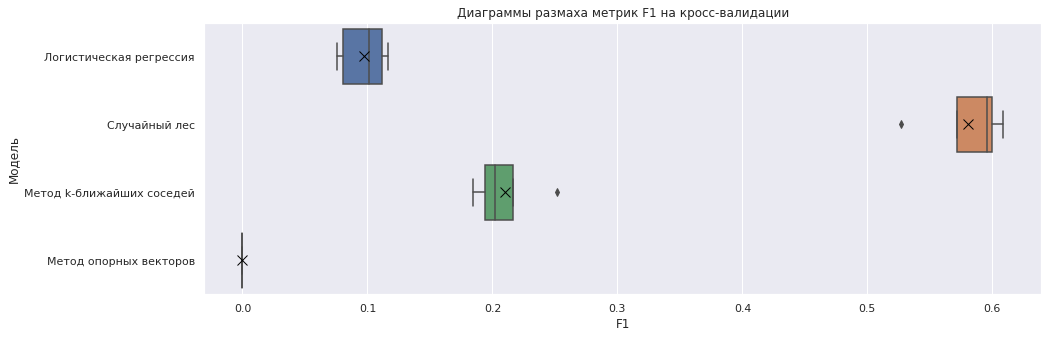

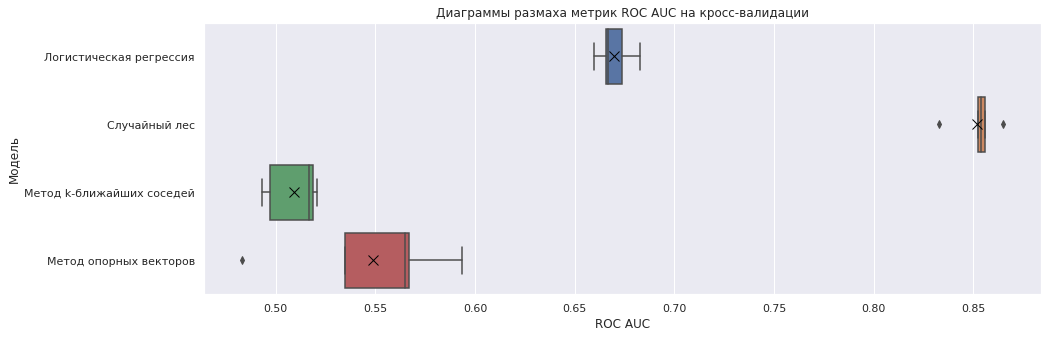

CPU times: user 5.76 s, sys: 284 ms, total: 6.04 s
Wall time: 1min 36s


In [147]:
%%time
get_scores(X_train, y_train)

#### Промежуточные выводы

Мы создали и обучили модели на основе логистической регрессии, случайного леса, метода ближайших соседей и метода опорных векторов. Для случайного леса удалось подобрать гиперпараметры таким образом, чтобы метрика $F1=0.58$, $AUC=0.85$. Результаты остальных моделей скорее печальны. Проверим, не связано ли это с тем, что численные признаки нашей модели не были отмасштабированы.

### Масштабирование численных признаков

Произведём масштабирование численных признаков таким образом, чтобы среднее выборки было равно нулю, а стандартное отклонение — единице.

In [148]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)

In [149]:
X_train_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,1.058568,1.715086,0.725639,-1.226059,-0.910256,0.641042,-1.030206,1.042084,-0.578313,-0.577735,0.907507
1,0.913626,-0.659935,-0.720757,0.413288,-0.910256,0.641042,-1.030206,-0.623556,1.729169,-0.577735,0.907507
2,1.079274,-0.184931,-1.805555,0.601687,0.808830,0.641042,0.970680,0.308128,1.729169,-0.577735,-1.101919
3,-0.929207,-0.184931,0.002441,-1.226059,0.808830,0.641042,-1.030206,-0.290199,-0.578313,-0.577735,0.907507
4,0.427035,0.955079,0.002441,0.548318,0.808830,-1.559960,0.970680,0.135042,1.729169,-0.577735,0.907507


In [150]:
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

In [151]:
X_test_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,-0.680735,-0.279932,0.725639,-1.226059,0.808830,0.641042,-1.030206,-0.095021,-0.578313,-0.577735,0.907507
1,-1.301915,-0.564935,-0.359158,0.877113,0.808830,-1.559960,-1.030206,-0.778941,1.729169,-0.577735,0.907507
2,-0.970619,0.100072,-0.359158,-1.226059,0.808830,-1.559960,0.970680,0.099469,-0.578313,1.730897,-1.101919
3,-0.121674,-0.469934,0.002441,1.011458,0.808830,-1.559960,-1.030206,-1.147374,-0.578313,1.730897,0.907507
4,-0.111321,-0.469934,-0.720757,0.023204,-0.910256,0.641042,0.970680,1.200283,-0.578313,1.730897,-1.101919


Снова обучим наши модели, но на этот раз на отмасштабированных данных.

#### Обучение и получение метрик

Логистическая регрессия
Метрика F1: 0.32
Метрика AUC: 0.76

Случайный лес
Метрика F1: 0.58
Метрика AUC: 0.85

Метод k-ближайших соседей
Метрика F1: 0.48
Метрика AUC: 0.72

Метод опорных векторов
Метрика F1: 0.51
Метрика AUC: 0.83


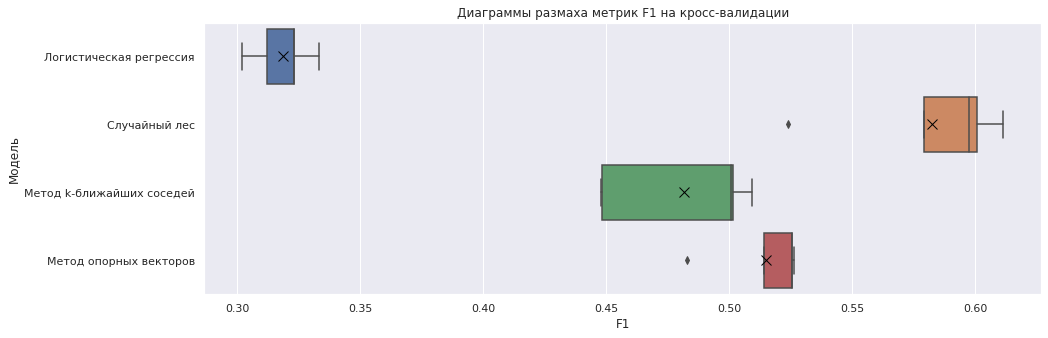

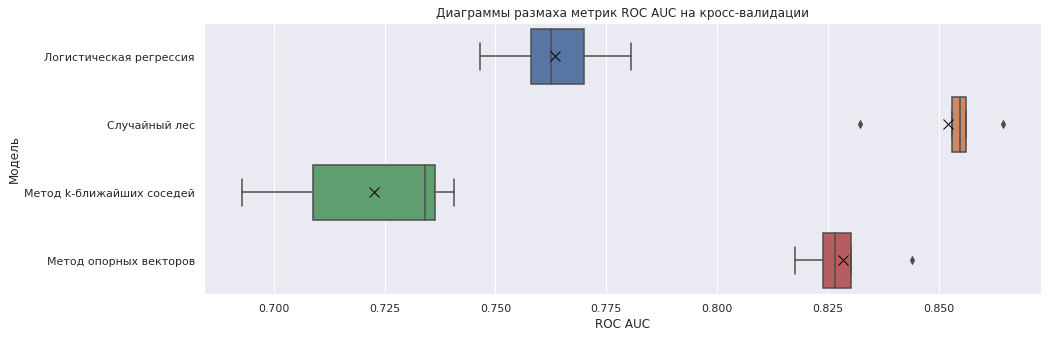

CPU times: user 6.17 s, sys: 263 ms, total: 6.43 s
Wall time: 1min 51s


In [152]:
%%time
get_scores(X_train_scaled, y_train)

#### Промежуточные выводы

После масштабирования параметров мы повторно обучили на них несколько моделей. При этом метрики некоторых моделей (логической регрессии, методов _k_-ближайших соседей и опорных векторов) заметно выросли. Метрики модели на основе случайного леса не изменились.

### Удаление параметра `estimated_salary`

На этапе исследовательского анализа данных мы обнаружили, что в колонке `estimated_salary` возможно содержатся некорректные данные. Попробуем удалить эту колонку из набора признаков и посмотрим, как изменятся метрики моделей.

In [153]:
X_train_scaled_short = X_train_scaled.drop('estimated_salary', axis=1)
X_test_scaled_short = X_test_scaled.drop('estimated_salary', axis=1)

#### Обучение и получение метрик

Логистическая регрессия
Метрика F1: 0.32
Метрика AUC: 0.76

Случайный лес
Метрика F1: 0.59
Метрика AUC: 0.85

Метод k-ближайших соседей
Метрика F1: 0.51
Метрика AUC: 0.77

Метод опорных векторов
Метрика F1: 0.52
Метрика AUC: 0.83


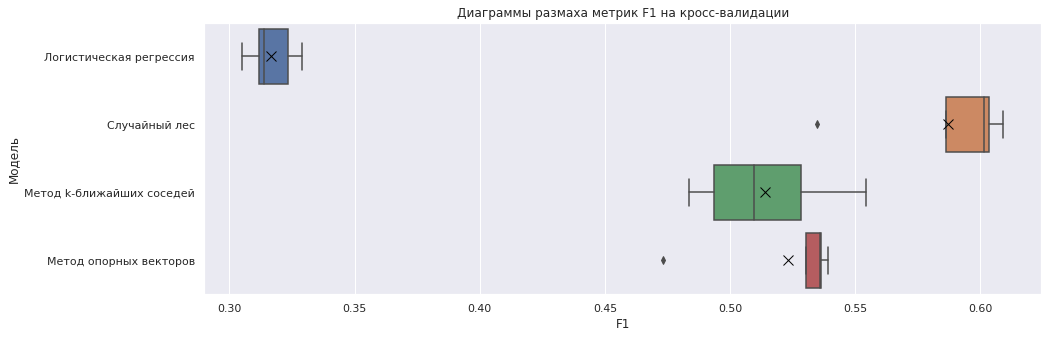

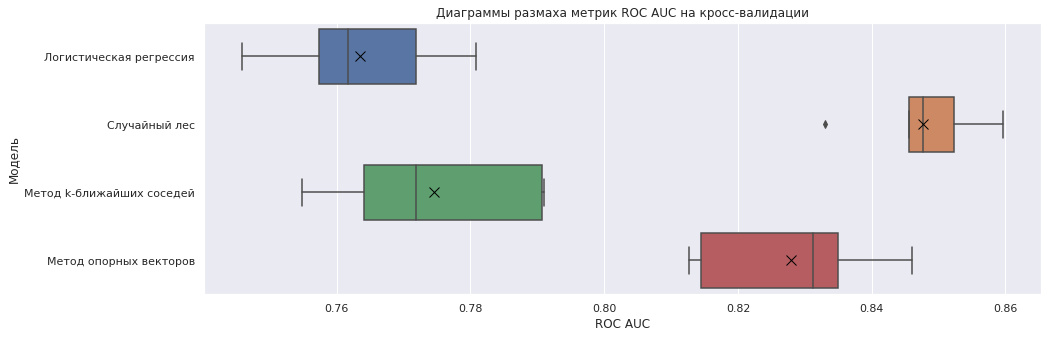

CPU times: user 5.51 s, sys: 244 ms, total: 5.75 s
Wall time: 1min 35s


In [154]:
%%time
get_scores(X_train_scaled_short, y_train)

#### Промежуточные выводы

Удаление колонки `estimated_salary` почти не сказалось на метриках моделей. При этом метрики модели на основе метода _k_-ближайших соседей даже немного выросли. С одной стороны можно сказать, что раз удаление колонки никак не сказалось на метриках, её можно было бы и не удалять. С другой стороны, удаление колонки данных позволяет сократить время вычислений, что довольно важно для некоторых задач.

### Предварительные выводы

Мы построили несколько моделей и обучили их на слегка различающихся наборах данных. После каждого обучения мы рассчитывали метрики _F1_ и _ROC-AUC_. Значения метрик для различных моделей и раличных наборов данных приведены в таблицах ниже.

*Таблица 1. Значения метрик F1 и AUC для различных моделей*

|Модель| F1/AUC для исходных параметров | F1/AUC для масштабированных параметров | F1/AUC для масштабированных и очищенных параметров|
---:|:---:|:---:|:---:|
Логистическая регрессия | 0.1/0.67 | 0.32/0.76 | 0.32/0.76 |
**Случайный лес** | **0.58/0.85** | **0.58/0.85** | **0.59/0.85** |
Метод _k_-ближайших соседей | 0.21/0.51 | 0.48/0.72 | 0.51/0.77 |
Метод опорных векторов | 0.0/0.55 | 0.51/0.83 | 0.52/0.83 |

Видно, что модель на основе случайного леса показала наилучшие метрики _F1_ и _ROC-AUC_ для всех наборов данных. Также интересно, что масштабирование данных существенно сказывается на метриках моделей на основе логистической регрессии, метода _k_-ближайших соседей и опорных векторов.

Удаление столбца с подозрительными данными `estimated_salary` почти не сказалось на метриках моделей, но позволило упростить расчёты.

## Борьба с дисбалансом

Полученные в предыдущем разделе метрики моделей далеки от идеала. Возможно это связано с тем, что в наших данных наблюдается дисбаланс классов: данных о клиентах, оставашихся в банке, существенно больше, чем данных о клиентах, покинувших банк. Посмотрим ещё раз на график, полученный нами на этапе исследовательского анализа данных.

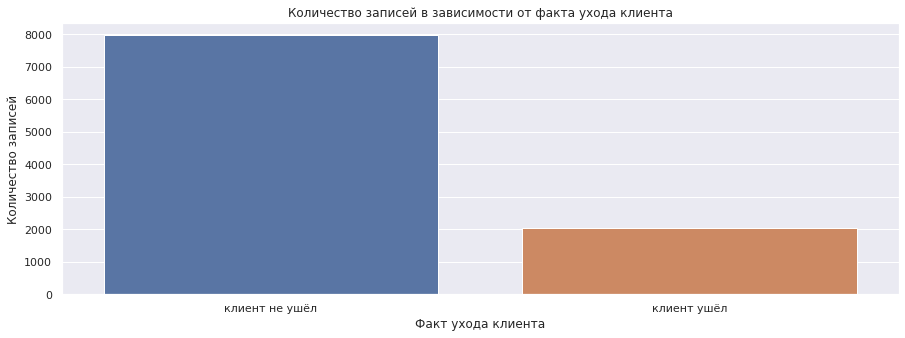

In [155]:
ax = sns.countplot(data=df, x='exited')
ax.set(xticklabels = (['клиент не ушёл', 'клиент ушёл']))
plt.title('Количество записей в зависимости от факта ухода клиента')
plt.xlabel('Факт ухода клиента')
plt.ylabel('Количество записей')
plt.show()

Проверим гипотезу о том, что низкие метрики моделей связаны именно с дисбалансом классов. Для этого сформируем новые учебные выборки, в которых данных об оставшихся и об ушедших клиентах будет примерно поровну. Новые выборки будет формировать на основе отмасштабированных данных без колонки `estimated_salary`.

Сначала сформируем выборку, в которой количество записей об оставшихся клиентах будет уменьшено до числа записей об ушедших клиентах.

In [156]:
print('Данные об оставшихся клиентах:', y_train[y_train == 0].size)
print('Данные об ушедших клиентах:', y_train[y_train == 1].size)

Данные об оставшихся клиентах: 6370
Данные об ушедших клиентах: 1630


In [157]:
y_train = y_train.reset_index(drop=True)

In [158]:
X_train_zeros = X_train_scaled_short[y_train == 0]
X_train_ones = X_train_scaled_short[y_train == 1]

y_train_zeros = y_train[y_train == 0]
y_train_ones = y_train[y_train == 1]

X_train_balanced_down = pd.concat([X_train_zeros.sample(n=y_train_ones.size), X_train_ones])
y_train_balanced_down = pd.concat([y_train_zeros.sample(n=y_train_ones.size), y_train_ones])

X_train_balanced_down, y_train_balanced_down = shuffle(X_train_balanced_down,
                                                       y_train_balanced_down,
                                                       random_state=42)

In [159]:
print('Данные об оставшихся клиентах:', y_train_balanced_down[y_train_balanced_down == 0].size)
print('Данные об ушедших клиентах:', y_train_balanced_down[y_train_balanced_down == 1].size)

Данные об оставшихся клиентах: 1630
Данные об ушедших клиентах: 1630


Теперь сформируем выборку, в которой количество записей об ушедших клиентах увеличено до числа записей об оставшихся клиентах.

In [160]:
X_balanced_up = pd.concat([X_train_zeros] + [X_train_ones] * 4)
y_balanced_up = pd.concat([y_train_zeros] + [y_train_ones] * 4)

X_train_balanced_up, y_train_balanced_up = shuffle(X_balanced_up, y_balanced_up, random_state=42)

In [161]:
print('Данные об оставшихся клиентах:', y_balanced_up[y_balanced_up == 0].size)
print('Данные об ушедших клиентах:', y_balanced_up[y_balanced_up == 1].size)

Данные об оставшихся клиентах: 6370
Данные об ушедших клиентах: 6520


Итак, мы создали выборки, в которых данные об ушедших и оставшихся клиентах распределены равномерно. Посмотрим, как это скажется на метриках наших моделей.

### Уменьшенный набор

#### Обучение и получение метрик

Логистическая регрессия
Метрика F1: 0.71
Метрика AUC: 0.77

Случайный лес
Метрика F1: 0.77
Метрика AUC: 0.85

Метод k-ближайших соседей
Метрика F1: 0.73
Метрика AUC: 0.81

Метод опорных векторов
Метрика F1: 0.77
Метрика AUC: 0.85


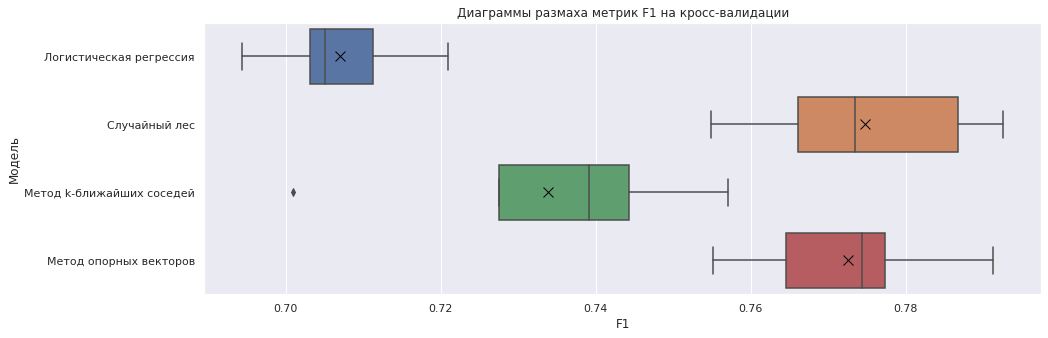

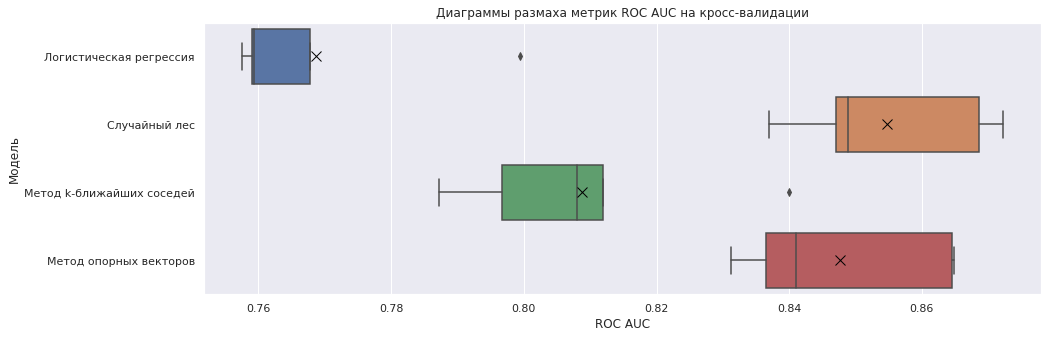

CPU times: user 2.87 s, sys: 116 ms, total: 2.98 s
Wall time: 39.2 s


In [162]:
%%time
get_scores(X_train_balanced_down, y_train_balanced_down)

### Расширенный набор

#### Обучение и получение метрик

Логистическая регрессия
Метрика F1: 0.7
Метрика AUC: 0.77

Случайный лес
Метрика F1: 0.95
Метрика AUC: 1.0

Метод k-ближайших соседей
Метрика F1: 0.93
Метрика AUC: 0.93

Метод опорных векторов
Метрика F1: 0.79
Метрика AUC: 0.87


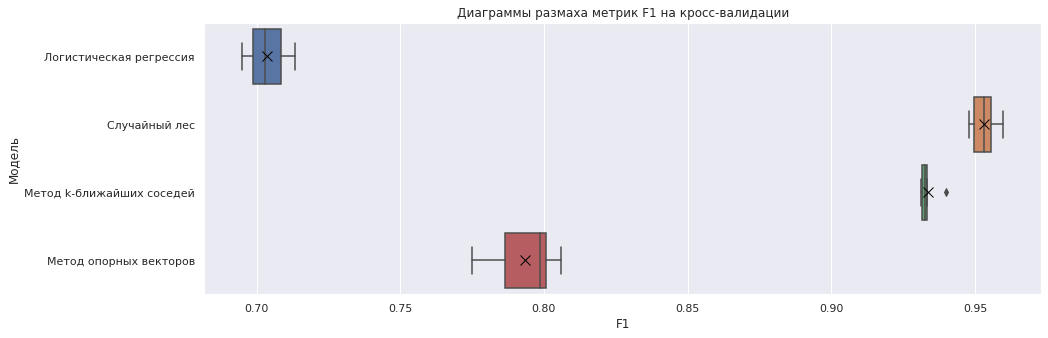

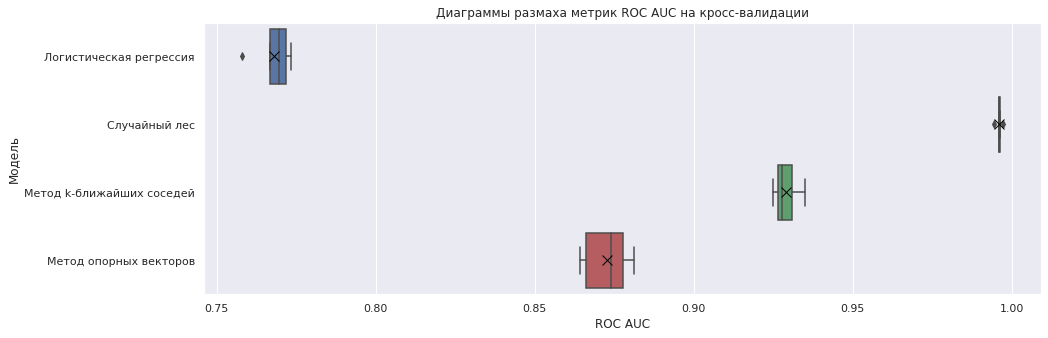

CPU times: user 11.7 s, sys: 415 ms, total: 12.2 s
Wall time: 4min 1s


In [163]:
%%time
get_scores(X_train_balanced_up, y_train_balanced_up)

#### Промежуточные выводы

Обученные на расширенном наборе данных модели на кросс-валидации показывают очень высокие метрики. Это связано с самой методикой расширения: мы многократно скопировали данные клиентов, которые ушли их банка, на этапе кросс-валидации копии этих данных попадают и в учебную и в валидационную выборки, поэтому итоговые метрики получаются завшенными. Чтобы устранить возникшую проблему вручную разделим данные на убебную и валидационную выборки, расширять будем только учебную выборку. Значения метрик будем получать без использования кросс-валидации.

#### Повторное создание расширенного набора

In [164]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_scaled_short,
                                                        y_train, test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y_train)

X_train2_zeros = X_train2[y_train2 == 0]
X_train2_ones = X_train2[y_train2 == 1]

y_train2_zeros = y_train2[y_train2 == 0]
y_train2_ones = y_train2[y_train2 == 1]

X_balanced_up2 = pd.concat([X_train2_zeros] + [X_train2_ones] * 4)
y_balanced_up2 = pd.concat([y_train2_zeros] + [y_train2_ones] * 4)

X_train_balanced_up2, y_train_balanced_up2 = shuffle(X_balanced_up2, y_balanced_up2, random_state=42)

#### Обучение и получение метрик

In [165]:
lr_best_f1 = 0
lr_best_auc = 0
for C in [.5, .6, .7, .8, .9, 1.]:
    lr_model = LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1, C=C)
    lr_model.fit(X_train_balanced_up2, y_train_balanced_up2)

    lr_pred = lr_model.predict(X_test2)

    lr_f1 = f1_score(y_test2, lr_pred)
    lr_auc = roc_auc_score(y_test2, lr_pred)
    
    if lr_f1 > lr_best_f1:
        lr_best_f1 = lr_f1
        lr_best_auc = lr_auc

print('Логистическая регрессия')
print('Метрика F1:', round(lr_best_f1, 2))
print('Метрика AUC:', round(lr_best_auc, 2))

Логистическая регрессия
Метрика F1: 0.48
Метрика AUC: 0.69


In [166]:
rfc_best_f1 = 0
rfc_best_auc = 0

for n_estimators in [80, 100, 120]:
    for max_depth in range(5, 20, 2):
        rfc_model = RandomForestClassifier(n_estimators=n_estimators, 
                                           max_depth=max_depth,
                                           random_state=42, n_jobs=-1)
        rfc_model.fit(X_train_balanced_up2, y_train_balanced_up2)

        rfc_pred = rfc_model.predict(X_test2)

        rfc_f1 = f1_score(y_test2, rfc_pred)
        rfc_auc = roc_auc_score(y_test2, rfc_pred)
        if rfc_f1 > rfc_best_f1:
            rfc_best_f1 = rfc_f1
            rfc_best_auc = rfc_auc

print('Случайный лес')
print('Метрика F1:', round(rfc_best_f1, 2))
print('Метрика AUC:', round(rfc_best_auc, 2))

Случайный лес
Метрика F1: 0.63
Метрика AUC: 0.76


In [167]:
knc_best_f1 = 0
knc_best_auc = 0

for weights in ['uniform', 'distance']:
    for n_neighbors in range(2, 10, 1):
        knc_model = KNeighborsClassifier(n_jobs=-1)
        knc_model.fit(X_train_balanced_up2, y_train_balanced_up2)

        knc_pred = knc_model.predict(X_test2)

        knc_f1 = f1_score(y_test2, knc_pred)
        knc_auc = roc_auc_score(y_test2, knc_pred)
        
        if knc_f1 > knc_best_f1:
            knc_best_f1 = knc_f1
            knc_best_auc = knc_auc

print('Случайный лес')
print('Метрика F1:', round(knc_best_f1, 2))
print('Метрика AUC:', round(knc_best_auc, 2))

Случайный лес
Метрика F1: 0.53
Метрика AUC: 0.73


In [168]:
svc_best_f1 = 0
svc_best_auc = 0

for C in [.5, .6, .7, .8, .9, 1.]:
    svc_model = SVC(random_state=42)
    svc_model.fit(X_train_balanced_up2, y_train_balanced_up2)

    svc_pred = svc_model.predict(X_test2)

    svc_f1 = f1_score(y_test2, svc_pred)
    svc_auc = roc_auc_score(y_test2, svc_pred)
    if svc_f1 > svc_best_f1:
        svc_best_f1 = svc_f1
        svc_best_auc = svc_auc

print('Случайный лес')
print('Метрика F1:', round(svc_best_f1, 2))
print('Метрика AUC:', round(svc_best_auc, 2))

Случайный лес
Метрика F1: 0.58
Метрика AUC: 0.77


### Предварительные выводы

Мы скорректировали баланс классов в обучающей выборке и снова обучили модели. Дополним ранее построенную таблицу метрик новыми данными.

*Таблица 2. Значения метрик F1 и AUC для различных моделей*

|Модель| F1/AUC для исходных параметров | F1/AUC для масштабированных параметров | F1/AUC для масштабированных и очищенных параметров| F1/AUC для уменьшенного набора | F1/AUC для расширенного набора |
---:|:---:|:---:|:---:|:---:|:---:|
Логистическая регрессия | 0.1/0.67 | 0.32/0.76 | 0.32/0.76 | **0.71/0.77** | **0.48/0.69** |
**Случайный лес** | **0.58/0.85** | **0.58/0.85** | **0.59/0.85** | **0.78/0.86** | **0.62/0.75** |
Метод _k_-ближайших соседей | 0.21/0.51 | 0.48/0.72 | 0.51/0.77 | **0.74/0.8** | **0.53/0.73** |
Метод опорных векторов | 0.0/0.55 | 0.51/0.83 | 0.52/0.83 | **0.77/0.85** | **0.58/0.77** |

Видно, что на сбалансированных данных все модели показали более высокие значения метрик _F1_ и _AUC_. Видно, что для имеющихся данных наилучшие метрики _F1/AUC_ обеспечивают модели на основе случайного леса и опорных векторов. 

Окончательный выбор модели будет зависеть от условий задачи, от того, насколько будет критична производительность или объяснимость модели, но если ориентироваться только на метрики _F1_ и _ROC-AUC_, то некоторое преимущество имеет модель на основе случайного леса, обученная на масштабированных и сбалансированных данных.

### Получение метрик на тестовой выборке

Посмотрим, каковы будут метрики обученной на сбалансированном наборе модели случайного леса на тестовой выборке.

In [169]:
%%time
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc_params = {'n_estimators': [80, 100, 120],
              'max_depth': range(5, 20, 2)}
rfc_model = GridSearchCV(estimator=rfc, param_grid=rfc_params, scoring='f1', n_jobs=-1)

rfc_model.fit(X_train_balanced_down, y_train_balanced_down)

CPU times: user 1.44 s, sys: 92.2 ms, total: 1.53 s
Wall time: 41.6 s


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 20, 2),
                         'n_estimators': [80, 100, 120]},
             scoring='f1')

In [170]:
rfc_pred = rfc_model.predict(X_test_scaled_short)
ultimate_f1 = f1_score(y_test, rfc_pred)
ultimate_auc = roc_auc_score(y_test, rfc_pred)

In [171]:
print('F1:', round(ultimate_f1, 2), '\nROC-AUC:', round(ultimate_auc,2))

F1: 0.59 
ROC-AUC: 0.77


Итак, на тестовой выборке модель показала неплохие значения метрик:
$$F1 = 0.6$$
$$AUC = 0.78$$

### Изучение моделей

Итак, мы обучили несколько моделей, получили метрики, наш проект близок к концу. Посмотрим повнимательнее на обученные модели, попытаемся понять, какую информацию они «выжали» из данных

In [172]:
f_importances = rfc_model.best_estimator_.feature_importances_

In [173]:
f_importances = pd.Series(data=f_importances.T, index=X_train_balanced_up.columns, name='feature_importance')

In [174]:
f_importances.sort_values(ascending=False).head().to_frame()

,feature_importance
age,0.324261
num_of_products,0.170402
balance,0.147817
credit_score,0.134061
tenure,0.078136


In [175]:
%%time
lr = LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1)
lr_params = {'C': [.5, .6, .7, .8, .9, 1.]}
lr_model = GridSearchCV(estimator=lr, param_grid=lr_params, scoring='f1', n_jobs=-1)
lr_model.fit(X_train_balanced_down, y_train_balanced_down)

CPU times: user 143 ms, sys: 10 ms, total: 153 ms
Wall time: 1.71 s


GridSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             scoring='f1')

In [176]:
lr_coef = lr_model.best_estimator_.coef_

In [177]:
lr_coef = pd.Series(data=lr_coef[0], index=X_train_balanced_up.columns, name='lr_coef')

In [178]:
lr_coef.sort_values(ascending=False, key=abs).head().to_frame()

,lr_coef
age,0.855074
is_active_member,-0.434747
geography_Germany,0.306264
gender_Male,-0.259804
balance,0.145411


Видно, что модель на основе случайного леса считает важнейшими факторами, влияющими на уход клиента из банка, возраст, кредитный рейтинг и баланс на счёте. Модель на основе линейной регрессии тоже считает возраст важнейшим критерием, но также ориентируется на то, является ли клиент активным и проживает ли в Германии. Более того, коэффициенты модели линейной регрессии позволяют прогнозировать, что вероятность ухода из банка повышается с увеличением возраста клиента, но уменьшается, если клиент активен.

## Тестирование моделей

Убедимся, что наши модели действительно позволяют получить ценные прогнозы. Для этого сравним метрики модели на основе случайного леса с метриками модели, которая всегда предсказывает наиболее часто встречающийся класс (0, клиент остался).

In [179]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_balanced_down, y_train_balanced_down)
d_pred = dummy.predict(X_test_scaled_short)
f_one = f1_score(y_test, d_pred)
auc = roc_auc_score(y_test, d_pred)
print('F1:', f_one, 'AUC:', auc)

F1: 0.0 AUC: 0.5


«Глупый» классификатор смог достичь метрик $F1=0.0$, $AUC=0.5$. Это ниже, чем у наших моделей, а значит они работают и позволяют получить новую информацию о клиентах!

## Общий вывод по проекту

Задачей данного проекта было прогнозирование оттока клиентов банка на основе имеющихся данных.

Был проведён исследовательский анализ данных, позволивший выявить ряд несущественных проблем с данными и одну колонку с возможно ошибочными данными.

Затем были созданы четыре модели, которые последовательно обучались с различными наборами данных, созданными на основе исходной таблицы. Оценка эффективности моделей производилась по метрикам _F1_ и _ROC AUC_.

В результате было установлено, что наилучшего значения метрики удаётся достичь для отмасштабированного и сбалансированного набора данных, из которого была исключена колонка с потенциально некорректными данными. Итоговая метрика _F1_ наилучшей модели на тестовых данных равна 0,6.

Ценность прогнозов моделей была показана путём сравнения с «глупым» классификатором, который на всех данных выдавал прогноз, что клиент останется в банке.

Полученные модели могут применяться при разработке маркетинговых стратегий, при изучении клиентской базы, чтобы целенаправлено работать с клиентами, которые могут уйти из банка.